<a href="https://colab.research.google.com/github/AlwaysEden/Temperature-Forecast/blob/main/Prophet_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os.path import split
import requests
import json
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import pandas as pd
from zoneinfo import ZoneInfo
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import numpy as np
from re import X

In [ ]:
def temp_totalData():  #기상청API에서 온도 데이터를 받아 파싱
  now = datetime.now(ZoneInfo('Asia/Seoul'))
  one_month_ago = now - timedelta(days=30)

  startDt = one_month_ago.strftime("%Y%m%d%H00")
  endDt = now.strftime("%Y%m%d%H00")
  print(startDt)
  print(endDt)

  # URL 문자열, stn=138(포항) 자세한 사항 기상청 참고
  url = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm5.php?tm1={startDt}&tm2={endDt}&obs=TA&stn=138&help=0&authKey=YOUR KEY'.format(startDt=startDt, endDt=endDt)

  # GET 요청
  response = requests.get(url)

  splited_response = response.text.splitlines()
  result_lines = splited_response[3:len(splited_response) - 1]

  temperature_list = []
  for line in result_lines:
    line = line.split(',')
    temperature_list.append(float(line[5]))

  # 예제 시계열 데이터 생성
  date_rng = pd.date_range(start=startDt, end=endDt, freq='h')
  df = pd.DataFrame({'ds': date_rng, 'y': temperature_list})

  return df

def test_totalData():  #기상청API에서 온도 데이터를 받아 파싱
  now = datetime.now(ZoneInfo('Asia/Seoul'))
  one_month_ago = now - timedelta(days=30)

  startDt = one_month_ago.strftime("%Y%m%d%H00")
  endDt = now.strftime("%Y%m%d%H00")
  print(startDt)
  print(endDt)

  # URL 문자열
  url = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm5.php?tm1={startDt}&tm2={endDt}&obs=TA&stn=138&help=0&authKey=YOUR_KEY'.format(startDt=startDt, endDt=endDt)

  # GET 요청
  response = requests.get(url)

  splited_response = response.text.splitlines()
  result_lines = splited_response[3:len(splited_response) - 1]

  temperature_list = []
  for line in result_lines:
    line = line.split(',')
    temperature_list.append(float(line[5]))

  date_rng = pd.date_range(start=startDt, end=endDt, freq='h')
  df = pd.DataFrame({'ds': date_rng, 'y': temperature_list})

  #고의적인 이상점 삽입
  outlier_indices = [710]  # 이상값을 삽입할 시작 인덱스
  outlier_duration = 3  # 각 이상값의 지속 시간 (3시간)
  for idx in outlier_indices:
      for i in range(outlier_duration):
          df.loc[idx + i, 'y'] += 5 * (i + 1)  # 점진적으로 증가

  return df

def data_plot(data):
  plt.figure(figsize=(16, 10))
  plt.plot(data['ds'], data['y'], linestyle='-')
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.title('Temperature Over Time')
  #data['y'].plot(figsize=(10, 6), title="Temperature Over Time", xlabel="ds", ylabel="y")
  plt.show()

202408151000
202409141000


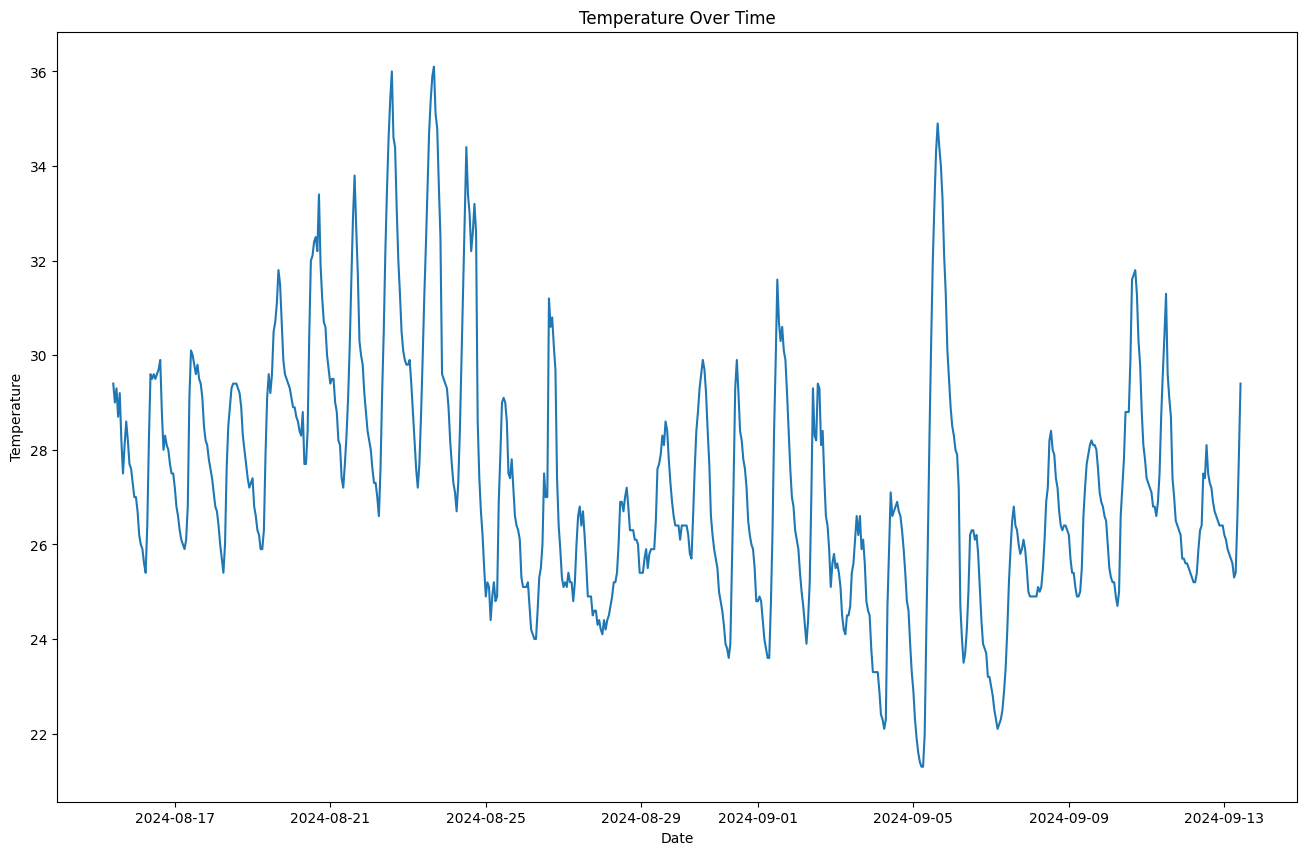

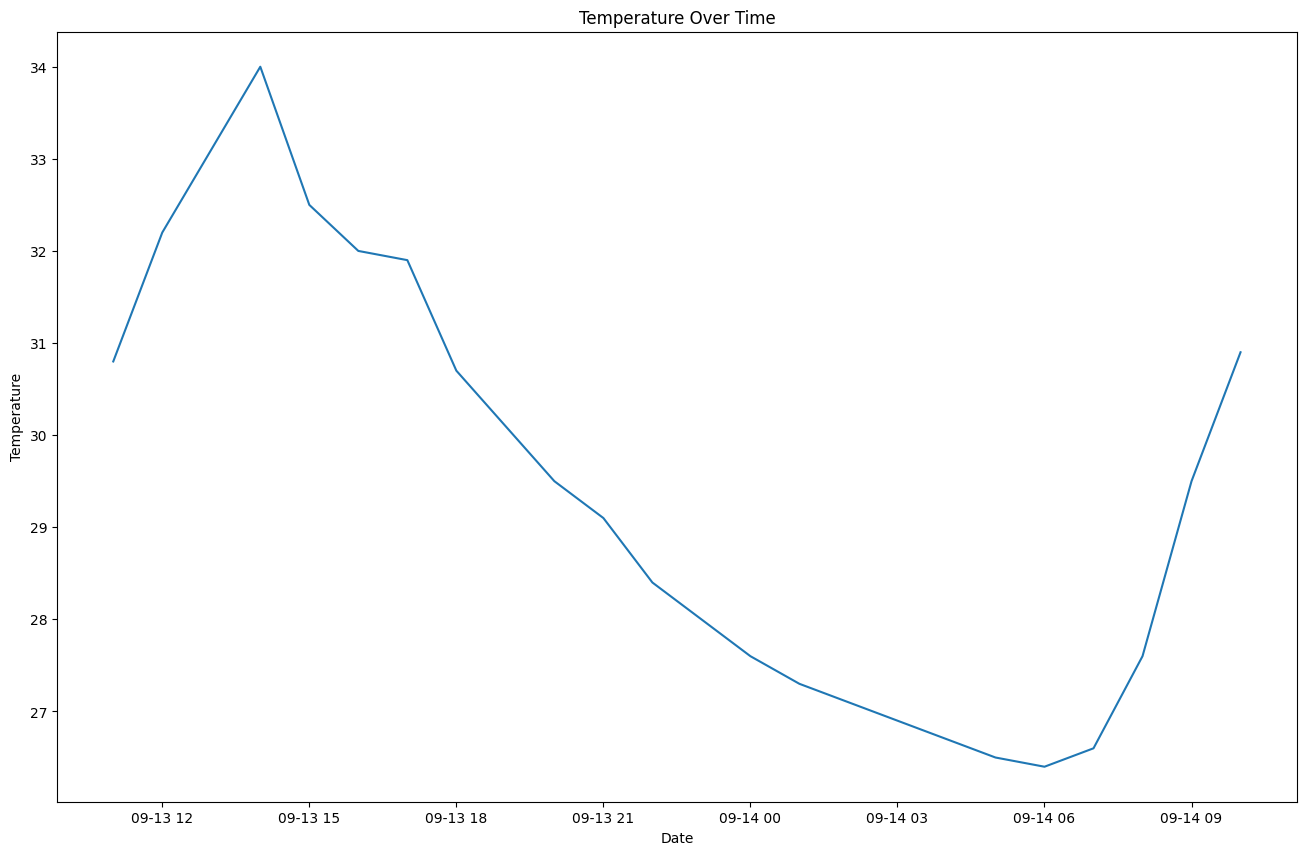

In [ ]:
#데이터 다운로드
steps = 24
temp_list = temp_totalData()
val_list = temp_list[-1*steps:] #가장 최근 데이터를 Validation 데이터로 분류
temp_list = temp_list[:(len(temp_list)-steps)]
data_plot(temp_list)
data_plot(val_list)

In [ ]:
#Prophet Model
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5, 1],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1, 5, 10],
    'n_changepoints': [30]
}

best_mae = float('inf')
best_params = None
best_forecast = None

for params in ParameterGrid(param_grid):
    model = Prophet(
        n_changepoints=params['n_changepoints'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
    )
    model.fit(temp_list)
    future = model.make_future_dataframe(periods=steps, freq='H')
    forecast = model.predict(future)

    mae = mean_absolute_error(temp_list['y'], forecast['yhat'][:len(temp_list)])
    if mae < best_mae:
      best_params = params
      best_mae = mae
      best_forecast = forecast

# 결과 시각화
fig = model.plot(best_forecast)

NameError: name 'ParameterGrid' is not defined

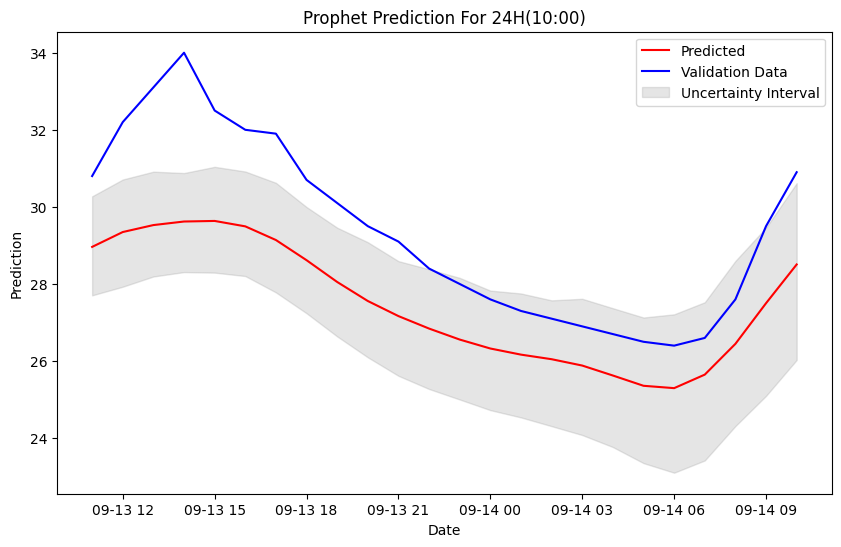

In [ ]:
import matplotlib.pyplot as plt

# 예측 데이터에서 학습 데이터 이후만 필터링
forecast_filtered = best_forecast[best_forecast['ds'] > temp_list['ds'].max()]

# 학습 데이터 제외한 시각화
plt.figure(figsize=(10, 6))
plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicted', color='red')
plt.plot(val_list['ds'][:steps], val_list['y'][:steps], label='Validation Data', color='blue')
plt.fill_between(
    forecast_filtered['ds'],
    forecast_filtered['yhat_lower'],
    forecast_filtered['yhat_upper'],
    color='gray', alpha=0.2, label='Uncertainty Interval'
)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Prophet Prediction For 24H(10:00)')
plt.show()

In [ ]:
#time = 0
upper_limit = 10
lower_limit = 0
for e in zip(val_list['y'][:steps], forecast_filtered['ds'],forecast_filtered['yhat']):
  error_range = 2 #날씨의 불확실성에 따른 기상청에서 인정하는 기온의 오차범위 2도.
  actual = round(e[0],2)
  lower_hat = round(e[2],2) - error_range
  upper_hat = round(e[2],2) + error_range
  if lower_hat > actual or actual > upper_hat:
      if lower_hat < actual:
        print(f"{e[1]}시점에서 예측값보다 실제값이 더 높습니다.")
      elif upper_hat > actual:
        print(f"{e[1]}시점에서 예측값보다 실제값이 더 낮습니다.")

2025-01-01 12:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-01 13:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-01 14:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-01 15:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-01 16:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-01 17:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-01 18:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-01 19:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-01 20:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-01 23:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 00:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 01:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 02:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 03:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 04:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 05:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 06:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 07:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 08:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 09:00:00시점에서 예측값보다 실제값이 더 높습니다.
2025-01-02 10:00:00시점에서 예측값보다 실제값이 더 높습니다.


# TEST MODE

202412011900
202412311900


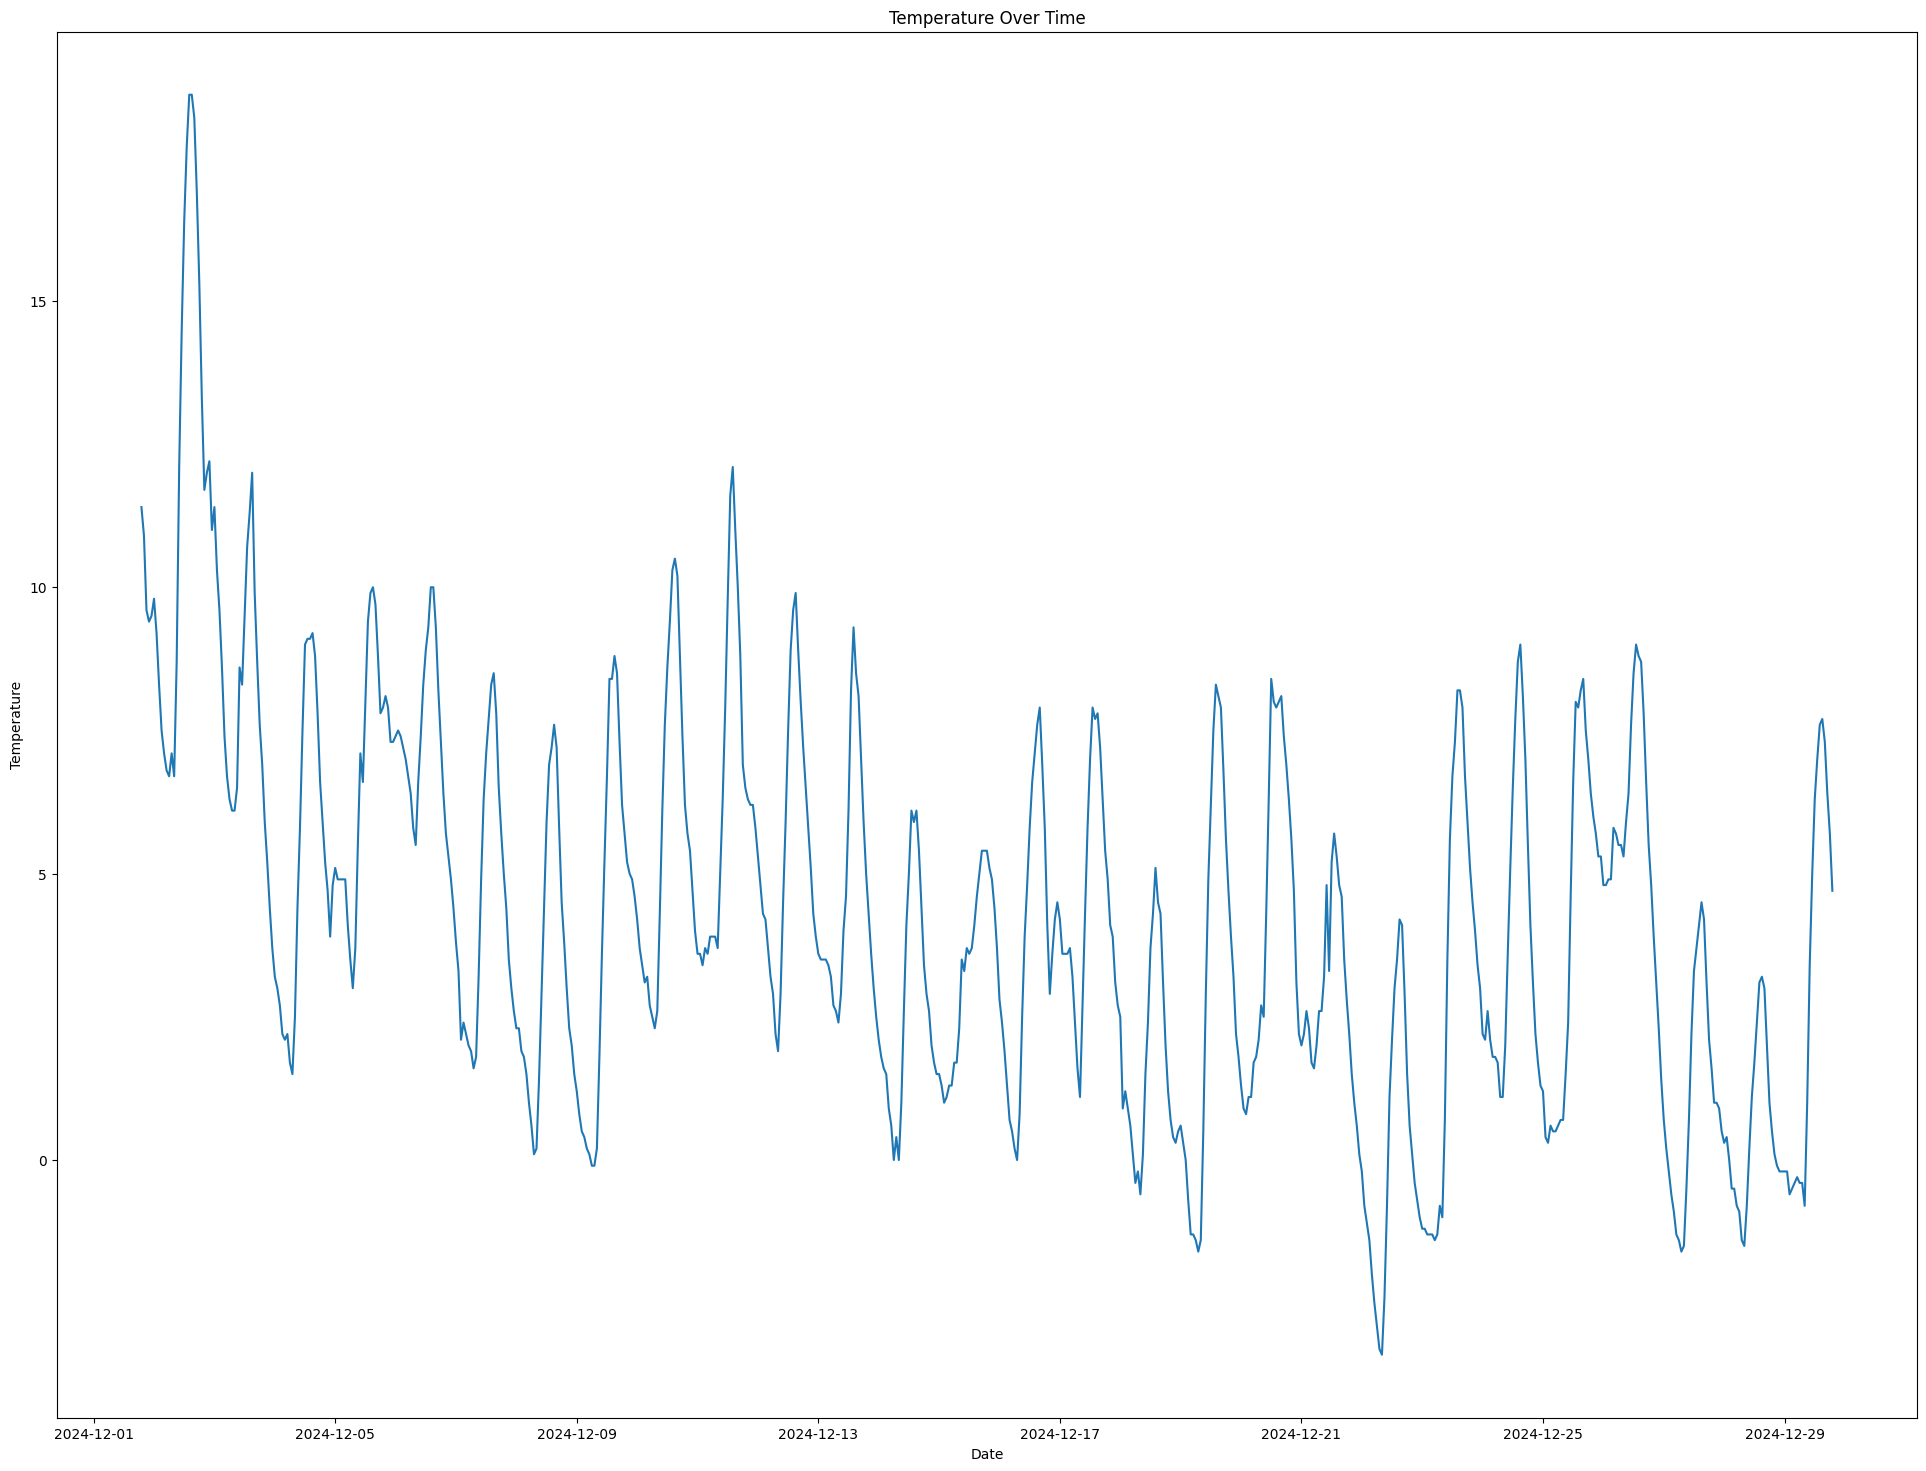

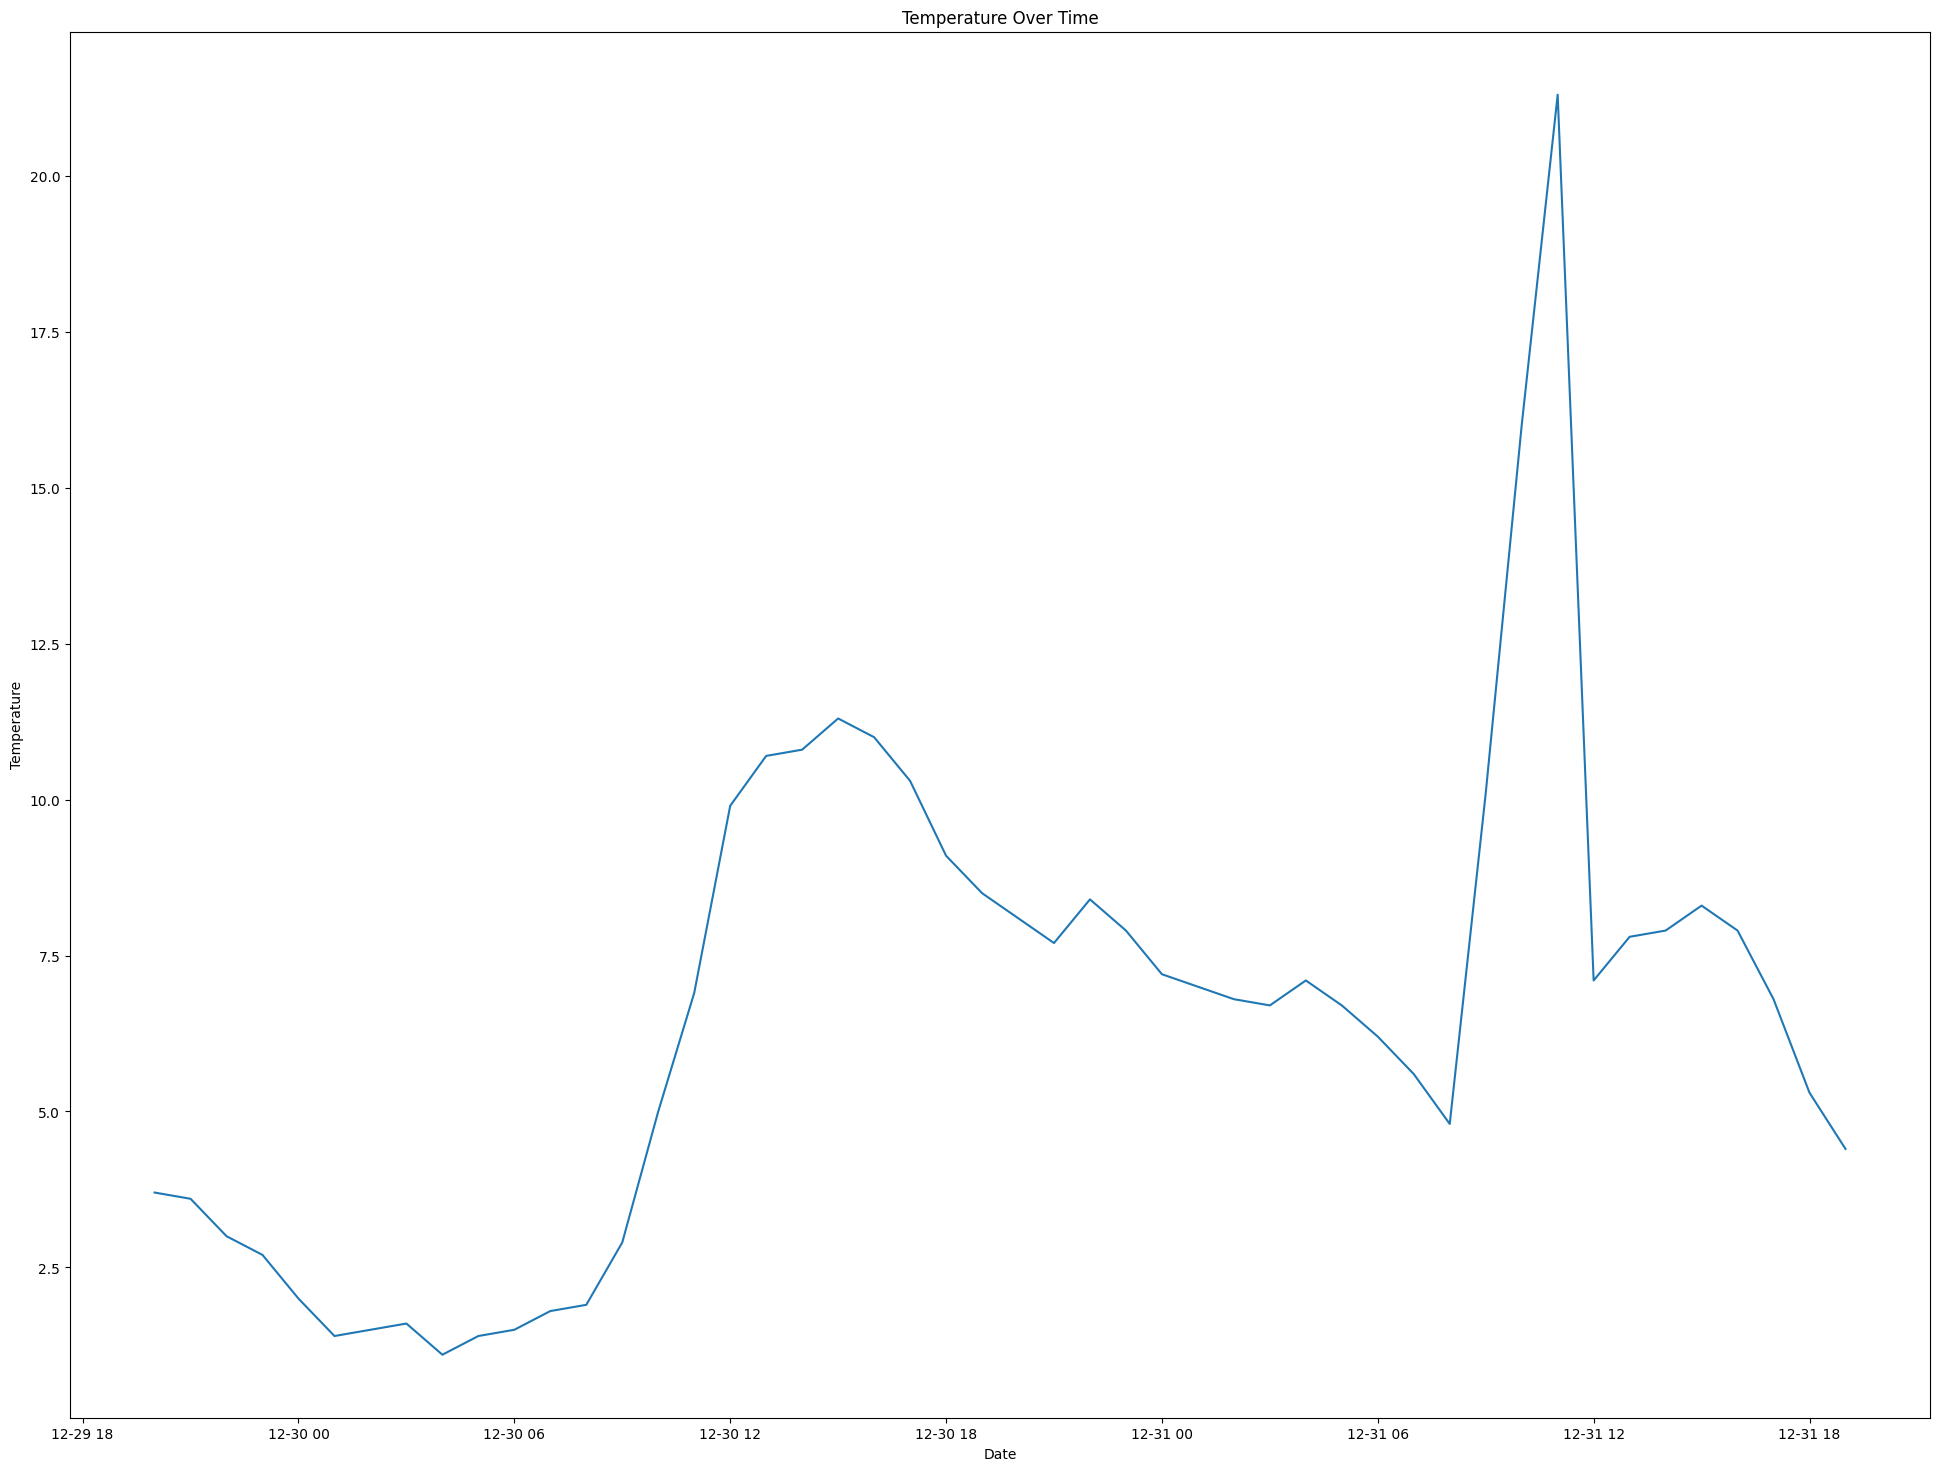

In [ ]:
#Test Mode
steps = 48
test_list = test_totalData()
val_list = test_list[-1*steps:] #가장 최근 데이터를 Validation 데이터로 분류
test_list = test_list[:(len(test_list)-steps)]
data_plot(test_list)
data_plot(val_list)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fcyk8ic/14jte2j2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fcyk8ic/jccm5mq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88081', 'data', 'file=/tmp/tmp_fcyk8ic/14jte2j2.json', 'init=/tmp/tmp_fcyk8ic/jccm5mq0.json', 'output', 'file=/tmp/tmp_fcyk8ic/prophet_modelce4c2jw6/prophet_model-20241231104620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version

{'changepoint_prior_scale': 0.5, 'n_changepoints': 30, 'seasonality_prior_scale': 10}


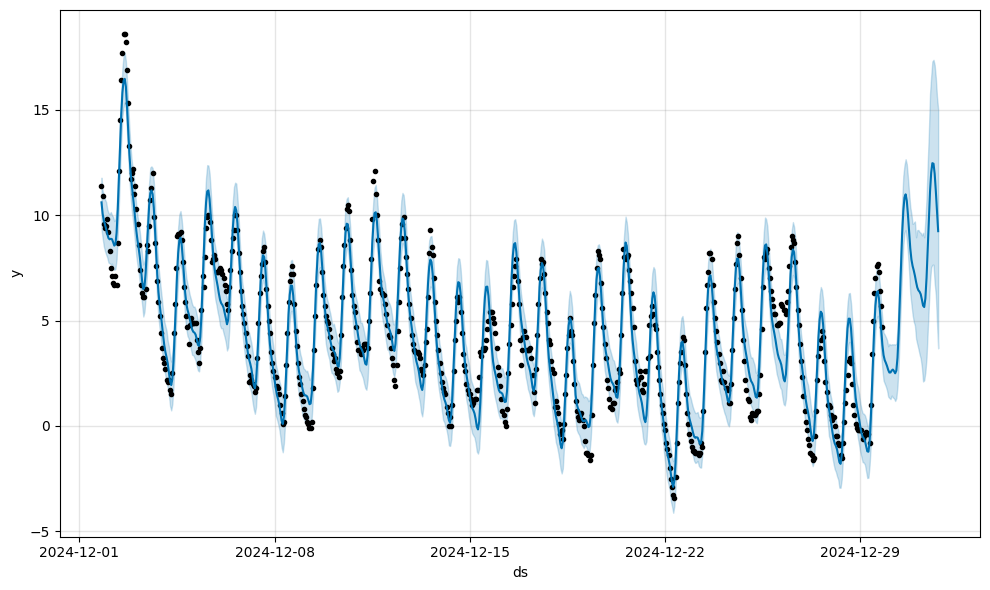

In [ ]:
#Prophet Model(Test Mode)
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1, 5, 10],
    'n_changepoints': [30]
}

best_mae = float('inf')
best_forecast = None
best_param = None

for params in ParameterGrid(param_grid):
    model = Prophet(
        n_changepoints=params['n_changepoints'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
    )
    model.fit(test_list)
    future = model.make_future_dataframe(periods=steps, freq='H')
    forecast = model.predict(future)

    mae = mean_absolute_error(test_list['y'], forecast['yhat'][:len(test_list)])
    if mae < best_mae:
      best_param = params
      best_mae = mae
      best_forecast = forecast

# 결과 시각화
fig = model.plot(best_forecast)


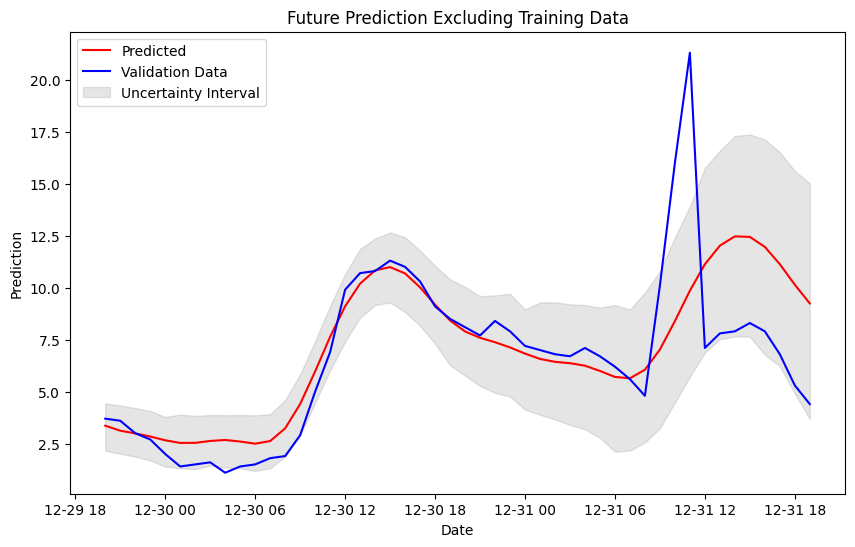

In [ ]:
#Visualization For Test Mode

# 예측 데이터에서 학습 데이터 이후만 필터링
forecast_filtered = best_forecast[best_forecast['ds'] > test_list['ds'].max()]

# 학습 데이터 제외한 시각화
plt.figure(figsize=(10, 6))
plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicted', color='red')
plt.plot(val_list['ds'][:steps], val_list['y'][:steps], label='Validation Data', color='blue')
plt.fill_between(
    forecast_filtered['ds'],
    forecast_filtered['yhat_lower'],
    forecast_filtered['yhat_upper'],
    color='gray', alpha=0.2, label='Uncertainty Interval'
)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Future Prediction Excluding Training Data')
plt.show()

In [ ]:
#time = 0
upper_limit = 10
lower_limit = 0
for e in zip(val_list['y'][:steps], forecast_filtered['ds'],forecast_filtered['yhat']):
  error_range = 2 #날씨의 불확실성에 따른 기상청에서 인정하는 기온의 오차범위 2도.
  actual = round(e[0],2)
  lower_hat = round(e[2],2) - error_range
  upper_hat = round(e[2],2) + error_range
  if lower_hat > actual or actual > upper_hat:
      if lower_hat < actual:
        print(f"{e[1]}시점에서 예측값보다 실제값이 더 높습니다.")
      elif upper_hat > actual:
        print(f"{e[1]}시점에서 예측값보다 실제값이 더 낮습니다.")

2024-12-31 10:00:00시점에서 예측값보다 실제값이 더 높습니다.
2024-12-31 11:00:00시점에서 예측값보다 실제값이 더 높습니다.
